# cells
---
Script to perform electron identification using cell-level information. Two separate approaches are tested: Convolutional- and graph neural networks.

---
## Initialisation

In [1]:
%matplotlib notebook

# Basic import(s)
import h5py
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# Pytorch import(s)
import torch
from torch.autograd import Variable
import torch.nn.functional as F
CUDA = torch.cuda.is_available()

# Project import(s)
from convert import *

[WARN] ROOT and/or root_numpy are not installed. This might lead to problems.


Using TensorFlow backend.


Load data from HDF5 file

In [2]:
with h5py.File('data/data_00000000.h5', 'r') as hf:
    data = hf['egamma'][:]
    pass

In [3]:
num_events = data.size
variables = list(data.dtype.names)

print "Read {} events.".format(num_events)
print "Variables:"
for var in variables:
    print "  {}".format(var)
    pass


Read 100000 events.
Variables:
  truth_pt
  truth_et
  truth_eta
  truth_phi
  truth_type
  truth_origin
  truth_PdgId
  cells_energy
  cells_gain
  cells_provenance
  cells_sampling
  cells_time
  cells_x
  cells_y
  cells_z
  cells_eta
  cells_phi
  signal


Prepare training inputs and -labels arrays.

In [4]:
# Determine network training features
features = list(filter(lambda name: name.startswith('cells_'), data.dtype.names))
print "Features:", features

# Prepare arrays
inputs = data[features]
labels = data[['signal']]

# Filter out any inf/nan samples
# @TODO:
#  - Figure out where these come from
M = np.array(inputs.tolist())
m_avg = np.zeros(M.shape)
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        m_avg[i][j] = np.mean(M[i][j])
        pass
    pass

msk_bad = np.any(np.isnan(m_avg) | np.isinf(m_avg), axis=1)

inputs = inputs[~msk_bad]
labels = labels[~msk_bad]

m_avg = m_avg[~msk_bad]

# Automatic feature standardisation
feat_mean = np.mean(m_avg, axis=0)
feat_std  = np.std (m_avg, axis=0)
#### for idx, feat in enumerate(features):
####     inputs[feat] -= feat_mean[idx]
####     inputs[feat] /= feat_std [idx]
####     pass

# Manual feature standardisation
for idx, feat in enumerate(features):
    print "  {:<16s}: {:-9.3f} ± {:-9.3f}".format(feat, feat_mean[idx], feat_std[idx])
    pass

inputs['cells_energy']     /= 1000.  # MeV -> GeV (?)
inputs['cells_provenance'] /= 1000.
inputs['cells_x']          /= 1000.  # mm -> m
inputs['cells_y']          /= 1000.  # mm -> m
inputs['cells_z']          /= 1000.  # mm -> m

Features: ['cells_energy', 'cells_gain', 'cells_provenance', 'cells_sampling', 'cells_time', 'cells_x', 'cells_y', 'cells_z', 'cells_eta', 'cells_phi']
  cells_energy    :   155.454 ±   241.237
  cells_gain      :     0.002 ±     0.007
  cells_provenance:   859.304 ±   654.474
  cells_sampling  :     2.978 ±     1.942
  cells_time      :    -0.040 ±     0.370
  cells_x         :    -2.813 ±  1073.805
  cells_y         :     6.220 ±  1082.372
  cells_z         :    -1.433 ±  2563.452
  cells_eta       :    -0.002 ±     1.296
  cells_phi       :     0.011 ±     1.755


---
## Visualisation

<IPython.core.display.Javascript object>


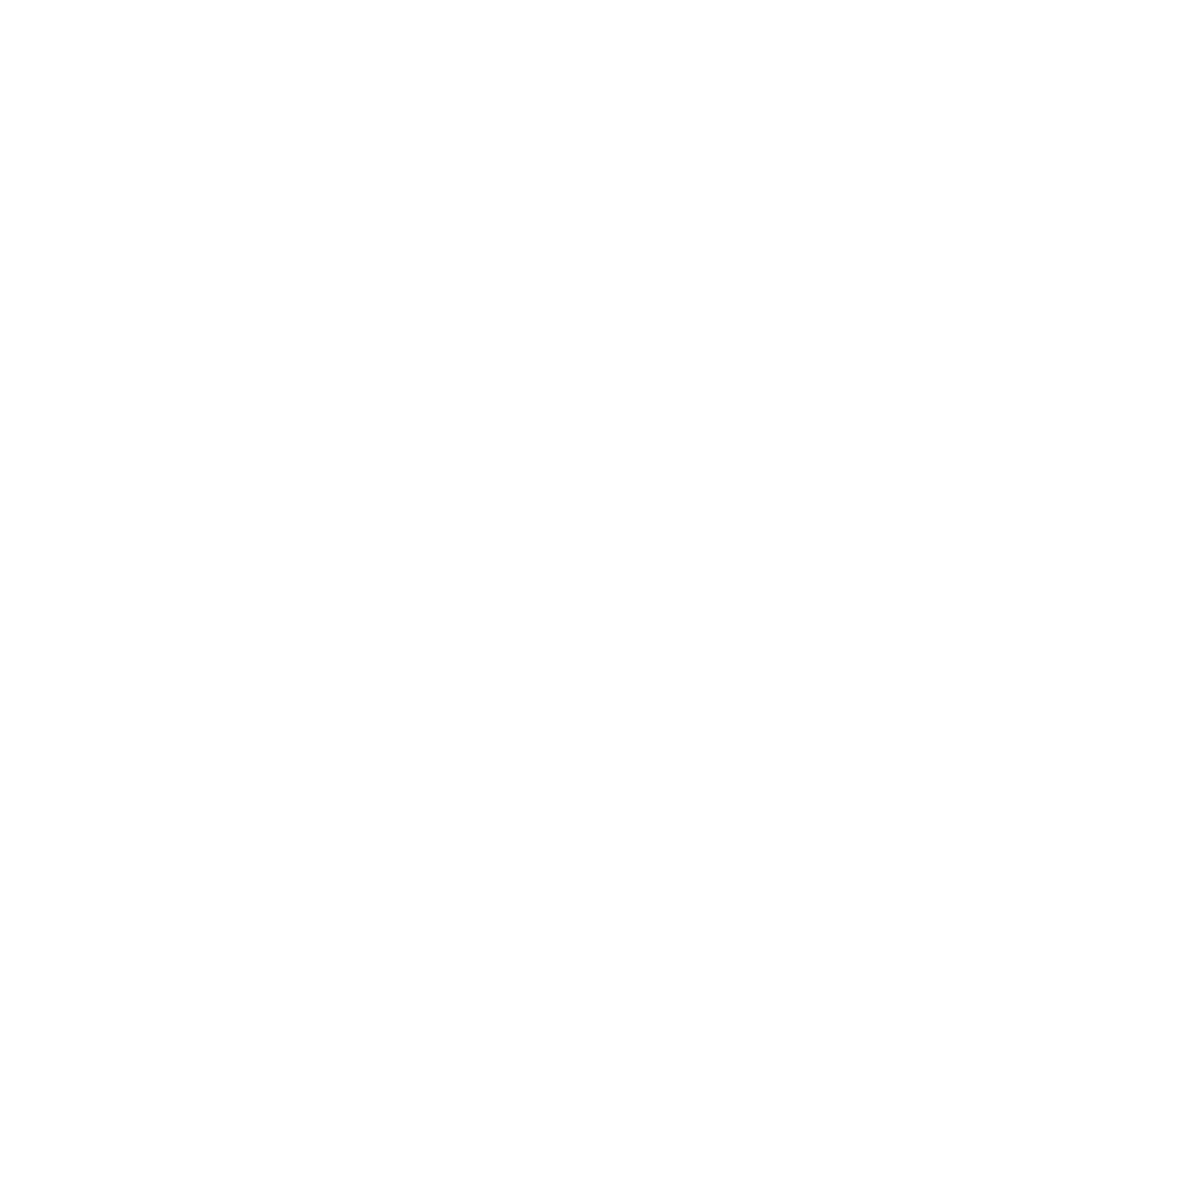

In [5]:
from mpl_toolkits.mplot3d import Axes3D

num_candidates = data.shape[0]

# Create figure
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

# Plot cells
for icand in range(20):
    x = data['cells_x'][icand]
    y = data['cells_y'][icand]
    z = data['cells_z'][icand]

    ax.scatter(x, y, z)  #, alpha=0.2)
    pass


# Draw end-cap dividers
x_ = np.linspace(-2000, 2000, 40 + 1, endpoint=True)
y_ = np.linspace(-2000, 2000, 40 + 1, endpoint=True)
X_, Y_ = np.meshgrid(x_, y_)
Z_ = np.ones_like(X_) * 3500
ax.plot_surface(X_, Y_, +Z_, color='gray', alpha=0.1)
ax.plot_surface(X_, Y_, -Z_, color='gray', alpha=0.1)

# Draw beam-line
z_ = np.linspace(-5000, 5000, 40 + 1, endpoint=True)
ax.plot(x_ * 0, y_ * 0, z_, color='gray')

# Plot simplistic detector
bins = 40
# -- ECAL barrel inner
r = 1500
x_ = np.linspace(-r, r, bins + 1)
z_ = np.linspace(-3500, 3500, bins + 1)
X_, Z_ = np.meshgrid(x_, z_)
Y_ = np.sqrt(r**2 - X_**2)
ax.plot_surface(X_, +Y_, Z_, color='gray', alpha=0.1)
ax.plot_surface(X_, -Y_, Z_, color='gray', alpha=0.1)

# -- ECAL barrel outer
r = 2000
x_ = np.linspace(-r, r, bins + 1)
z_ = np.linspace(-3500, 3500, bins + 1)
X_, Z_ = np.meshgrid(x_, z_)
Y_ = np.sqrt(r**2 - X_**2)
ax.plot_surface(X_, +Y_, Z_, color='gray', alpha=0.1)
ax.plot_surface(X_, -Y_, Z_, color='gray', alpha=0.1)

# Decorations
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]')
ax.set_xlim(-2000,2000)
ax.set_ylim(-2000,2000)
ax.set_zlim(-5000,5000)

# Show
plt.show()

---
## GNN

Create sample generator.

In [6]:
def generator_ (inputs, labels):
    """
    Generate properly formatted training examples and -labels.
    
    Yields:
        h, y: Tuple of training example and -label.
    """
    for idx in range(inputs.shape[0]):
        
        # Numpy arrays
        h_ = np.array(inputs[idx].tolist()).T
        y_ = labels[idx].astype(float).reshape(-1,)
        
        # Pytorch tensors
        h_ = torch.from_numpy(h_).type(dtype)
        y_ = torch.from_numpy(y_).type(dtype)
        
        # Put on GPU
        if CUDA:
            h_, y_ = h_.cuda(), y_.cuda()
            pass
        
        yield h_, y_

generator = generator_(inputs, labels)

Define grid operators, inducing adjacency measures.

In [7]:
# Fuzz-factor to avoid divergences
eps = np.finfo(float).eps

# Fixed column indices
ix   = features.index('cells_x')
iy   = features.index('cells_y')
iz   = features.index('cells_z')
iphi = features.index('cells_phi')
ieta = features.index('cells_eta')

# Row-normalisation decorator
def _row_normalise (operator):
    """
    Function decorator, ensuring that the matrix output of some operator is row-
    normalised, in order to resemble a transition probability matrix.
    
    Arguments:
        M: Arbitrary 2D matrix.
        
    Returns:
        Row-normalised version of M.
    """
    def wrapper (*args, **kwargs):
        M = operator(*args, **kwargs)
        assert np.all(M.data.numpy() >= 0)
        return M / torch.sum(M, dim=1).view(M.shape[0],1).expand(*M.shape)
    return wrapper


# Remove diagonal
def _zero_diagonal (operator):
    """
    Function decorator, zeroing out the diagonal entries of the matrix output of
    some operator.
    
    Arguments:
        M: Arbitrary 2D matrix.
        
    Returns:
        M, with diagonal elemets set to zero.
    """
    def wrapper (*args, **kwargs):
        M = operator(*args, **kwargs)
        msk = torch.eye(*M.shape).type(torch.ByteTensor)
        M[msk] *= 0
        return M
    return wrapper


# Identity matrix
@_row_normalise
def identity_matrix (h):
    """
    Compute identity matrix for sample `h`.
    
    Arguments:
        h: Input matrix with shape (num_vertices, num_features).
        
    Returns:
        Identity matrix with shape (num_vertices, num_vertices).
    """
    # Number of vertices
    N = h.shape[0]
    return Variable(torch.eye(N,N), requires_grad=False)


# Adjacency matrix
@_row_normalise
@_zero_diagonal
def euclidean_adjacency_matrix (h):
    """
    Compute fixed Euclidean-distance adjacency matrix for sample `h`.

    Arguments:
        h: Input matrix with shape (num_vertices, num_features).
        
    Returns:
        Euclidean-distance adjancency matrix with shape (num_vertices, 
            num_vertices), row-normalised and with zeroed-out diagonal elements. 
    """
    # Number of vertices
    N = h.shape[0]
    
    # Vertex coordinates
    x = h[:,ix]
    y = h[:,iy]
    z = h[:,iz]

    # Grid coordinates
    X = x.expand(N,N)
    Y = y.expand(N,N)
    Z = z.expand(N,N)

    # Pair-wise coordinate differences
    dX = X - X.transpose(0,1)
    dY = Y - Y.transpose(0,1)
    dZ = Z - Z.transpose(0,1)

    # Inverse Euclidean distance
    # @TODO: 
    #  - Take time into account? Causal distance?
    D = 1. / torch.sqrt(torch.pow(dX, 2.) + torch.pow(dY, 2.) + torch.pow(dZ, 2.) + eps)
    return D 


@_row_normalise
@_zero_diagonal
def dR_adjacency_matrix (h):
    """
    Compute fixed dR-distance adjacency matrix for sample `h`.
    
    Arguments:
        h: Input matrix with shape (num_vertices, num_features).
        
    Returns:
        Detector-dR-distance adjancency matrix with shape (num_vertices, 
            num_vertices), row-normalised and with zeroed-out diagonal elements.
    """
    pi   = np.pi
    twopi = 2. * pi
    
    # Number of vertices
    N = h.shape[0]
    
    # Vertex coordinates
    eta = h[:,ieta]
    phi = h[:,iphi]
    
    # Grid coordinates
    Eta = eta.expand(N,N)
    Phi = phi.expand(N,N)
    
    # Pair-wise coordinate differences
    dEta = Eta - Eta.transpose(0,1)
    dPhi = Phi - Phi.transpose(0,1)  
    
    # Ensure dPhi in [-π, π]
    # @FIXME: Currently, phi are not guaranteed to be within [0, 2π], hence the 
    #       while loop below. This should be addressed upstream!
    while True:
        msk = (dPhi >  pi).data.type(torch.ByteTensor)
        if not msk.numpy().any():
            break
        dPhi[msk] -= twopi
        pass

    while True:
        msk = (dPhi < -pi).data.type(torch.ByteTensor)
        if not msk.numpy().any():
            break
        dPhi[msk] += twopi
        pass
    
    assert np.all((dPhi.data.numpy() >= -pi) & (dPhi.data.numpy() <= pi)), (Phi, dPhi)
    
    # Inverse dR-distance
    D = 1. / torch.sqrt(torch.pow(dEta, 2.) + torch.pow(dPhi, 2.) + eps) 
    return D 

def maxout(h, axis=0):
    """Maxout function over vertices.
    
    Arguments:
        h: Input matrix with shape (num_vertices, num_features).

    Returns:
        Vector with shape (num_features,), holding the maximal value for each 
            feature over the set of vertices.
    """
    return torch.max(h, dim=axis)[0]

Define GNN module

In [8]:
class NodeUpdate (torch.nn.Module):
    def __init__ (self, input_size, output_size, num_kernels, activation):
        """NodeUpdate from 'Neural Message Passing for Jet Physics'."""
        super(NodeUpdate, self).__init__()
        
        # Check(s)
        # ...
    
        # Member variable(s)
        self._activation = activation
        self._kernels    = torch.nn.ParameterList([torch.nn.Parameter(torch.nn.init.xavier_uniform(torch.zeros(input_size, output_size)), requires_grad=True) for _ in range(num_kernels)])
        return
    
    def forward (self, h, operators):
        assert len(operators) == len(self._kernels)
        
        terms = [torch.mm(torch.mm(A, h), theta).view(A.shape[0], theta.shape[1], 1) for (A,theta) in zip(operators, self._kernels)]
        # @TODO:
        #  - Add learnable weights in sum?
        return torch.sum(torch.cat(terms, dim=2), dim=2)
    pass
        
        
class GNN (torch.nn.Module):
    def __init__ (self, operators, architecture):
        """Graph neural network."""
        super(GNN, self).__init__()

        # Check(s)
        assert isinstance(operators, list)
        assert isinstance(architecture, list)
        assert all(map(lambda e: isinstance(e, int), architecture))
        # ...
        
        # NOTE:
        # -----
        # We assume that e.g. `architecture = [16,10,10]` means that the input 
        # has 16 features, and that we should add a final, linear layer with 
        # dimensions `(16,1)` followed by sigmoid activation
        
        self._operators   = operators
        self._updates     = [NodeUpdate(dim_in, dim_out, len(self._operators), torch.nn.Tanh()) for (dim_in, dim_out) in zip(architecture[:-1], architecture[1:])]
        self._classifier  = torch.nn.Linear(architecture[-1], 1)

        self._module_list = torch.nn.ModuleList(self._updates + [self._classifier])

        self._layers      = list()
        return
    
    def forward (self, h):
        
        # Perform successive NodeUpdates
        for update in self._updates:

            # Construct linear operators for current input dimensions
            operators = [operator(h) for operator in self._operators]

            # Perform NodeUpdate
            h = update.forward(h, operators)
            pass
        
        # Reduction to fixed size
        h = maxout(h)

        # Map to probability
        return torch.nn.Sigmoid()(self._classifier(h))
    pass

Trying out recurrent layers...

In [9]:
hidden_size = 7   # GRU output features
num_layers = 2     # GRU layers
input_size = 3
seq_len = 10
batch = 32

rnn = torch.nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
input = Variable(torch.randn(batch, seq_len, input_size))
h0 = Variable(torch.randn(batch, num_layers, hidden_size))
output, hn = rnn(input)#, h0)
print output.shape, hn.shape

torch.Size([32, 10, 7]) torch.Size([2, 32, 7])


Construct GNN model

In [10]:
gnn = GNN([identity_matrix, euclidean_adjacency_matrix, dR_adjacency_matrix], [len(features),40,40,40])
if CUDA:
    gnn.cuda()
    pass

Perform training

In [11]:
# Placeholders
h = Variable(torch.zeros(1,1))
y = Variable(torch.zeros(1,))
dtype = torch.FloatTensor

# Loss
binary_crossentropy = torch.nn.BCELoss()

# Optimiser
optimiser = torch.optim.Adam(gnn.parameters(), lr=1e-04)

# Create validation set
validation = [next(generator) for _ in range(2000)]

# Event loop
mult = 10
stop = 20000
print "== Start"
for step, (h_, y_) in enumerate(generator):
    
    # Stop condition
    if stop and (step == stop):
        print "   Stopping at {}".format(step)
        break
    
    # Logging
    if step % mult == 0:
        print "== {}".format(step)
        if step == 10 * mult:
            mult *= 10
            pass
        pass
            
    # Fill placeholders
    h.data = h_
    y.data = y_
    
    # Get prediction, compute loss, perform back-propagation
    pred = gnn.forward(h)
    loss = binary_crossentropy(pred, y)
    loss.backward()
    
    # Print validation loss
    if step % len(validation) == 0:
        val_loss = 0.
        for h_, y_ in validation:
            # Fill placeholders
            h.data = h_
            y.data = y_
            pred = gnn.forward(h)
            val_loss += binary_crossentropy(pred, y).data[0]
            pass
        val_loss /= len(validation)
        print "validation loss ({}): {}".format(len(validation), val_loss)
        pass

    # Draw diagram
    if step == 0:
        from torchviz import make_dot
        params = {str(i): param for (i,param) in enumerate(gnn.parameters())}
        params['input']  = h  # Not showing up...
        params['output'] = y  # Not showing up...
        dot = make_dot(loss, params=params)
        for fmt in ['png', 'pdf']:
            dot.format = fmt
            dot.render('output/model')
            pass
        pass
    
    # Update parameters
    optimiser.step()
    optimiser.zero_grad()
    pass
print "== Done"

== Start
== 0
validation loss (2000): 1.48148151669
== 10
== 20
== 30
== 40
== 50
== 60
== 70
== 80
== 90
== 100
== 200
== 300
== 400
== 500
== 600
== 700
== 800
== 900
== 1000
== 2000
validation loss (2000): 0.355359477445
== 3000
== 4000
validation loss (2000): 0.330859124387
== 5000
== 6000
validation loss (2000): 0.297582433123
== 7000
== 8000
validation loss (2000): 0.275287511739
== 9000
== 10000
validation loss (2000): 0.292193638308
validation loss (2000): 0.289471899925
validation loss (2000): 0.259513553547
validation loss (2000): 0.252514339236
validation loss (2000): 0.280910882277
   Stopping at 20000
== Done


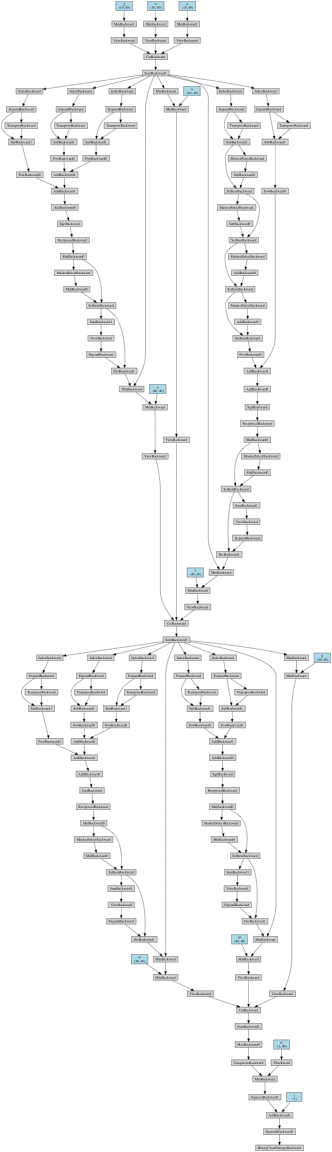

In [12]:
Image(filename='output/model.png')

Plot classifier distributions

In [13]:
preds  = list()
labels = list()
for h_, y_ in validation:
    h.data = h_
    y.data = y_
    pred = gnn.forward(h)
    preds .append(float(pred.data.numpy()))
    labels.append(float(y.data.numpy()))
    pass

<IPython.core.display.Javascript object>


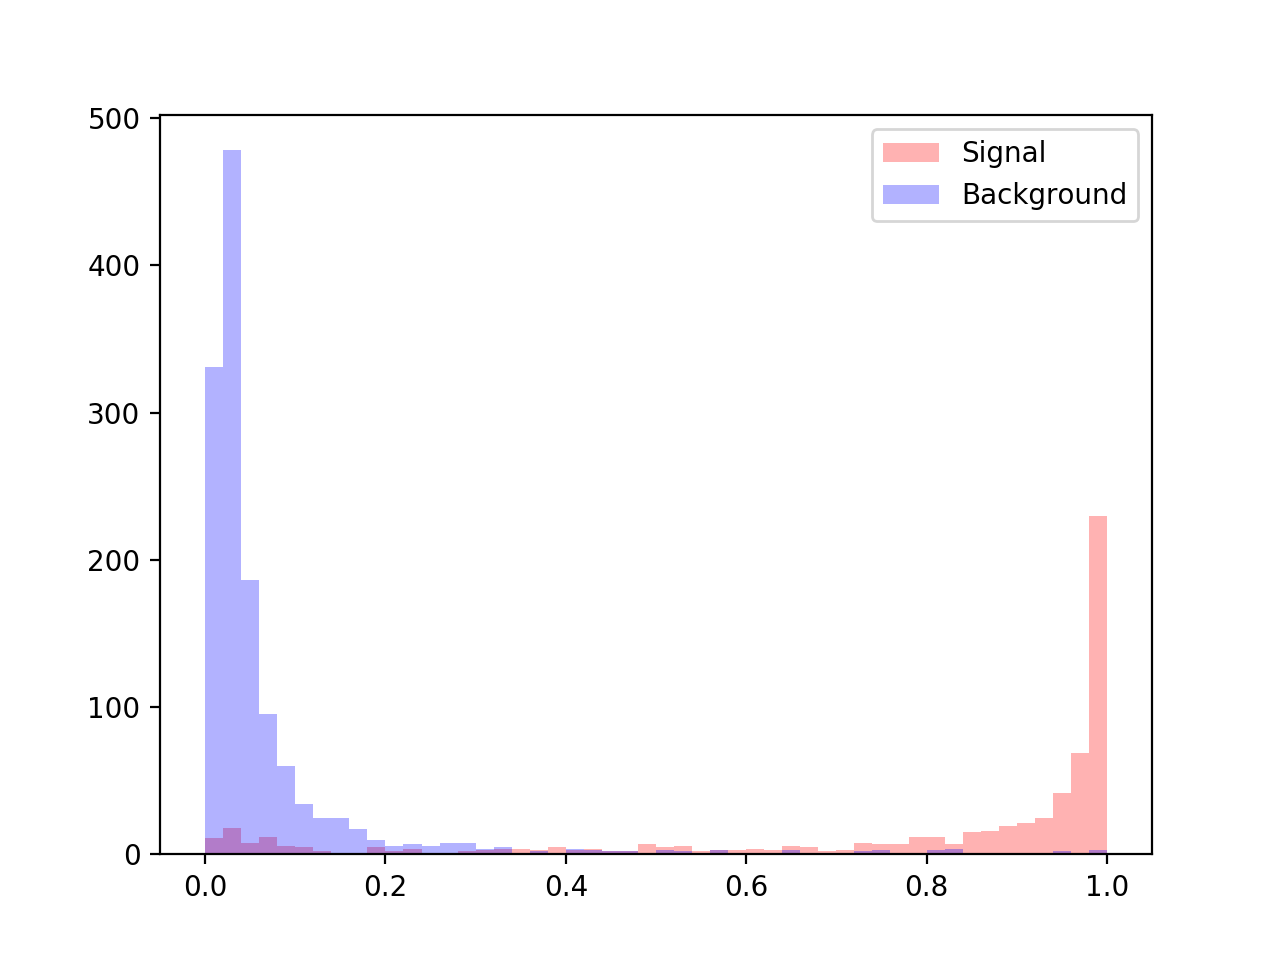

In [15]:
%matplotlib notebook
bins = np.linspace(0, 1, 50 +  1, endpoint=True)
preds  = np.array(preds)
labels = np.array(labels)
plt.hist(preds[labels == 1], bins=bins, color='red',  alpha=0.3, label='Signal')
plt.hist(preds[labels == 0], bins=bins, color='blue', alpha=0.3, label='Background')
plt.legend()
plt.show()